# Bollinger Bands

In [1]:
import yahoo_fin.stock_info as si
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import stdev

In [2]:
infosys_data = si.get_data("INFY", start_date="2020-01-01", end_date="2020-12-31", index_as_date = True, interval="1d")

In [3]:
data_frame = infosys_data['close']
data_frame = pd.DataFrame({'Close': infosys_data['close'].tolist()}, index = infosys_data.index)
data_frame['BOLU'] = np.nan
data_frame['SMA'] = np.nan
data_frame['BOLD'] = np.nan

In [4]:
def bollinger_bands(data, n):
    sma, bolu, bold = [], [], []
    for i in range(0, len(data['Close']) - n):
        sma_i = np.sum(data['Close'][i:(n+i)])/n
        sma.append(sma_i)
        bolu_i = sma[i] + 2 * stdev(data['Close'][i:(n+i)])
        bolu.append(bolu_i)
        bold_i = sma[i] - 2 * stdev(data['Close'][i:(n+i)])
        bold.append(bold_i)
    return (bolu, sma, bold)

In [5]:
data_frame['BOLU'][19:] = bollinger_bands(data_frame, 19)[0]
data_frame['SMA'][19:] = bollinger_bands(data_frame, 19)[1]
data_frame['BOLD'][19:] = bollinger_bands(data_frame, 19)[2]

In [6]:
def generate_signal(data, number):
    signals_list = []
    counter_buy = 0
    counter_sell = 0
    for i in range(0, len(data['Close'])):
        if data['Close'][i] > data['BOLU'][i]:
            counter_sell = counter_sell + 1
            if counter_sell == number:
                signals_list.append(-1)
                counter_sell = 0
            else:
                signals_list.append(0)
        elif data['Close'][i] < data['BOLD'][i]:
            counter_buy = counter_buy + 1
            if counter_buy == number:
                signals_list.append(1)
                counter_buy = 0
            else:
                signals_list.append(0)
        else:
            signals_list.append(0)    
    return signals_list

In [13]:
data_frame['Signals'] = generate_signal(data_frame, 4)

In [14]:
data_frame['Max'] = np.nan

In [15]:
for i in range(0, len(data_frame['Max'])):
    if data_frame['BOLU'][i] >= data_frame['Close'][i]:
        data_frame['Max'][i] = data_frame['BOLU'][i]
    else:
        data_frame['Max'][i] = data_frame['Close'][i]

C:\Users\Bartek\AppData\Local\Temp/ipykernel_22164/2208725419.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['Max'][i] = data_frame['Close'][i]
C:\Users\Bartek\AppData\Local\Temp/ipykernel_22164/2208725419.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['Max'][i] = data_frame['BOLU'][i]


In [16]:
data_frame['Min'] = np.nan

In [17]:
for i in range(0, len(data_frame['Min'])):
    if data_frame['BOLD'][i] <= data_frame['Close'][i]:
        data_frame['Min'][i] = data_frame['BOLD'][i]
    else:
        data_frame['Min'][i] = data_frame['Close'][i]

C:\Users\Bartek\AppData\Local\Temp/ipykernel_22164/4074555107.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['Min'][i] = data_frame['Close'][i]
C:\Users\Bartek\AppData\Local\Temp/ipykernel_22164/4074555107.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['Min'][i] = data_frame['BOLD'][i]


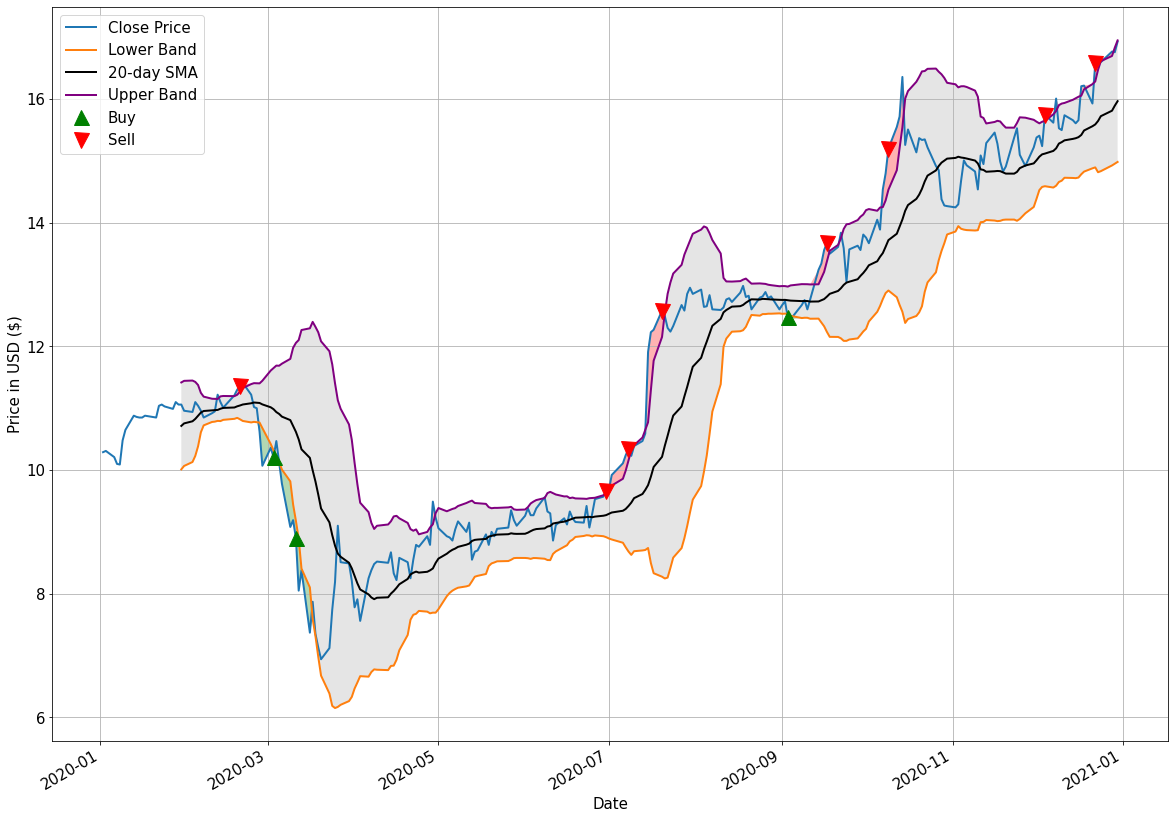

In [18]:
fig = plt.figure(figsize = (20, 15))
plt.tick_params(axis = 'both', labelsize = 15)
data_frame['Close'].plot(lw = 2., label = 'Close Price')
data_frame['BOLD'].plot( lw = 2., label = 'Lower Band')
data_frame['SMA'].plot(color = 'black',lw = 2., label = '20-day SMA')
data_frame['BOLU'].plot(color = 'purple', lw = 2., label = 'Upper Band')
plt.fill_between(data_frame.index, data_frame['BOLD'], data_frame['BOLU'], facecolor='grey', alpha = 0.2)
plt.fill_between(data_frame.index, data_frame['Max'], data_frame['BOLU'], facecolor='red', alpha = 0.3)
plt.fill_between(data_frame.index, data_frame['Min'], data_frame['BOLD'], facecolor='green', alpha = 0.3)
plt.plot(data_frame[data_frame['Signals'] == 1].index, data_frame['Close'][data_frame['Signals'] == 1], '^', markersize = 15,
         color = 'green', label = 'Buy')
plt.plot(data_frame[data_frame['Signals'] == -1].index, data_frame['Close'][data_frame['Signals'] == -1], 'v', markersize = 15,
         color = 'red', label = 'Sell')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Price in USD ($)', fontsize = 15)
plt.legend(loc = 'upper left', fontsize = 15)
plt.grid()

# Backtesting

In [40]:
def backtest(data, initial_capital, hold):
    total_list = []
    simple_returns = []
    initial_capital_list = float(initial_capital)
    cumulated_returns = [initial_capital_list]
    cash = float(initial_capital)
    holding = float(0)
    control_value = False
    for i in range(0, len(data['Signals'])):
        if data['Signals'][i] == 1:
            control_value = True
            cash = cash - float(hold) * data_frame['Close'][i]
            holding = float(hold) * data_frame['Close'][i]
        elif data['Signals'][i] == -1 and holding > 0.0:
            control_value = False
            cash = cash + holding
            holding = float(0)
        elif data_frame['Signals'][i] == 0:
            if control_value == True:
                holding = float(hold) * data['Close'][i]
        total = cash + holding
        total_list.append(total)
    for i in range(0, len(total_list) - 1):
        return_value = total_list[i + 1]/total_list[i] - float(1)
        simple_returns.append(return_value)
    for i in range(0, len(simple_returns)):
        cumulated_value = cumulated_returns[i] * (simple_returns[i] + float(1))
        cumulated_returns.append(cumulated_value)
    return cumulated_returns  

In [41]:
data_frame['Cumulative Returns'] = backtest(data_frame, 10000, 100)

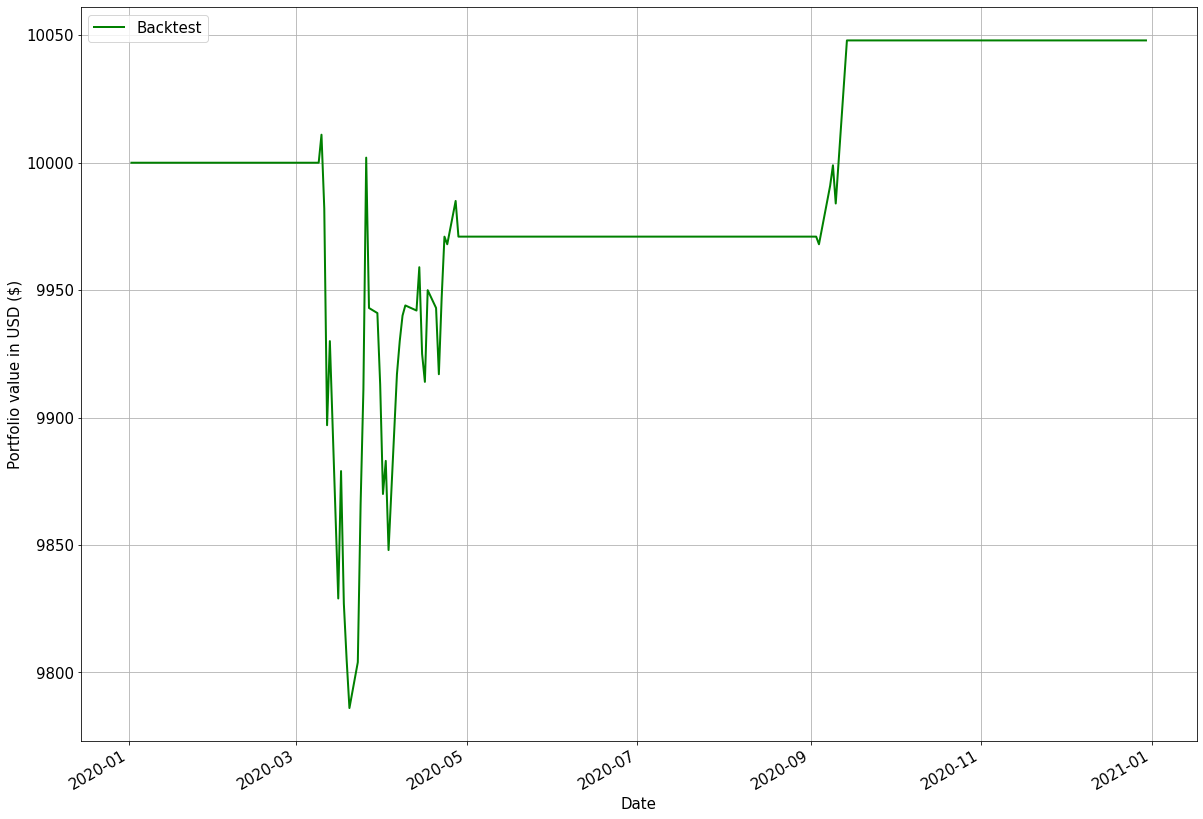

In [42]:
fig = plt.figure(figsize = (20, 15))
plt.tick_params(axis = 'both', labelsize = 15)
data_frame['Cumulative Returns'].plot(lw = 2., color = 'green', label = 'Backtest')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Portfolio value in USD ($)', fontsize = 15)
plt.legend(loc = 'upper left', fontsize = 15)
plt.grid()

In [43]:
print('Infosys (INFY) equity value as of December 31th 2020')
print("%.2f" % data_frame['Cumulative Returns'].tail(1))

print('Absolute return as of December 31th 2020')
print("%.2f" % (((data_frame['Cumulative Returns'].tail(1)/10000.0) - 1.0)*100))

Infosys (INFY) equity value as of December 31th 2020
10048.00
Absolute return as of December 31th 2020
0.48
